# Scope of the Report

This report is going to use the data set to conduct a classification task by using Multiple Layer Perceptron (MLP) classifiers. 

A facial expression recognition from Kaggle is selected. The images are classified into 6 classes as below. The number of cases in each class are shown as well.

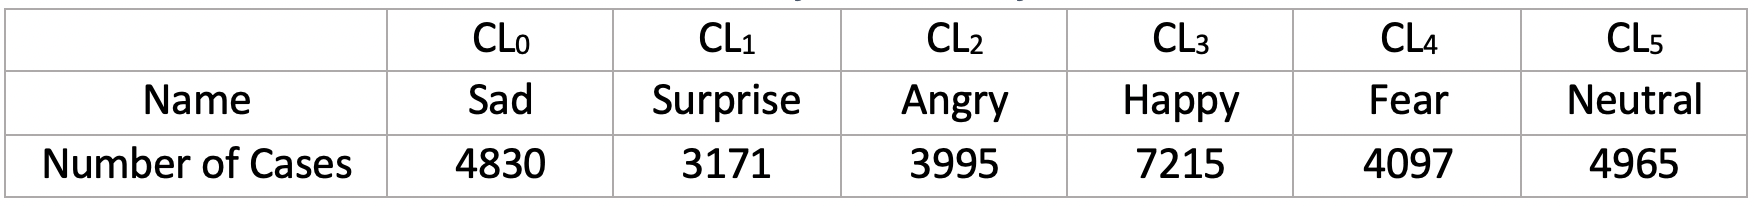

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load required packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import time

In [3]:
# Preset some parameters
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams.update({'font.size': 16})
seed = 2022

## Data preprocessing

Each case is a 48 × 48image. Since TensorFlow doesn’t understand the concept of 2D image, each image must be loaded and converted to a 1D array. 

To reduce the computing time, the image will be converted to grayscale image. Thus, each case contains 2304 features (each feature represents a pixel in the real image). 

The value of each pixel will between 0 and 255. However, it will be normalized by divided by 255 to make each value between 0 and 1. 

In [4]:
CL = ["sad", "surprise", "angry", "happy", "fear", "neutral"] # Class 0 = sad, Class 1 = surprise, Class 2 = angry, Class 3 = happy, Class 4 = fear, Class 5 = neutral
n_class = len(CL)

In [5]:
df = pd.read_csv("/content/gdrive/MyDrive/MATH 6373/Homework 2/Data Set/df.csv")
df.iloc[:, 1:] = 1 - df.iloc[:, 1:]/255

s_df = df.copy()

feature_len = len(s_df.iloc[0, 1:])

In [6]:
s_df.head()

,Label,0,1,2,3,4,5,6,7,8,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,0,0.964706,0.964706,0.960784,0.956863,0.941176,0.937255,0.894118,0.807843,0.729412,...,0.952941,0.945098,0.945098,0.945098,0.941176,0.941176,0.941176,0.945098,0.937255,0.925490
1,0,0.458824,0.635294,0.749020,0.796078,0.819608,0.823529,0.827451,0.811765,0.796078,...,0.125490,0.129412,0.125490,0.125490,0.125490,0.125490,0.125490,0.125490,0.125490,0.125490
2,0,0.878431,0.843137,0.792157,0.764706,0.682353,0.635294,0.603922,0.576471,0.576471,...,0.839216,0.729412,0.658824,0.627451,0.619608,0.623529,0.635294,0.729412,0.878431,0.964706
3,0,0.447059,0.431373,0.403922,0.396078,0.376471,0.407843,0.670588,0.831373,0.839216,...,0.745098,0.701961,0.607843,0.525490,0.466667,0.411765,0.400000,0.384314,0.388235,0.372549
4,0,0.952941,0.956863,0.956863,0.960784,0.964706,0.964706,0.960784,0.956863,0.956863,...,0.682353,0.658824,0.635294,0.694118,0.678431,0.670588,0.694118,0.717647,0.741176,0.749020


## Plot one image per class

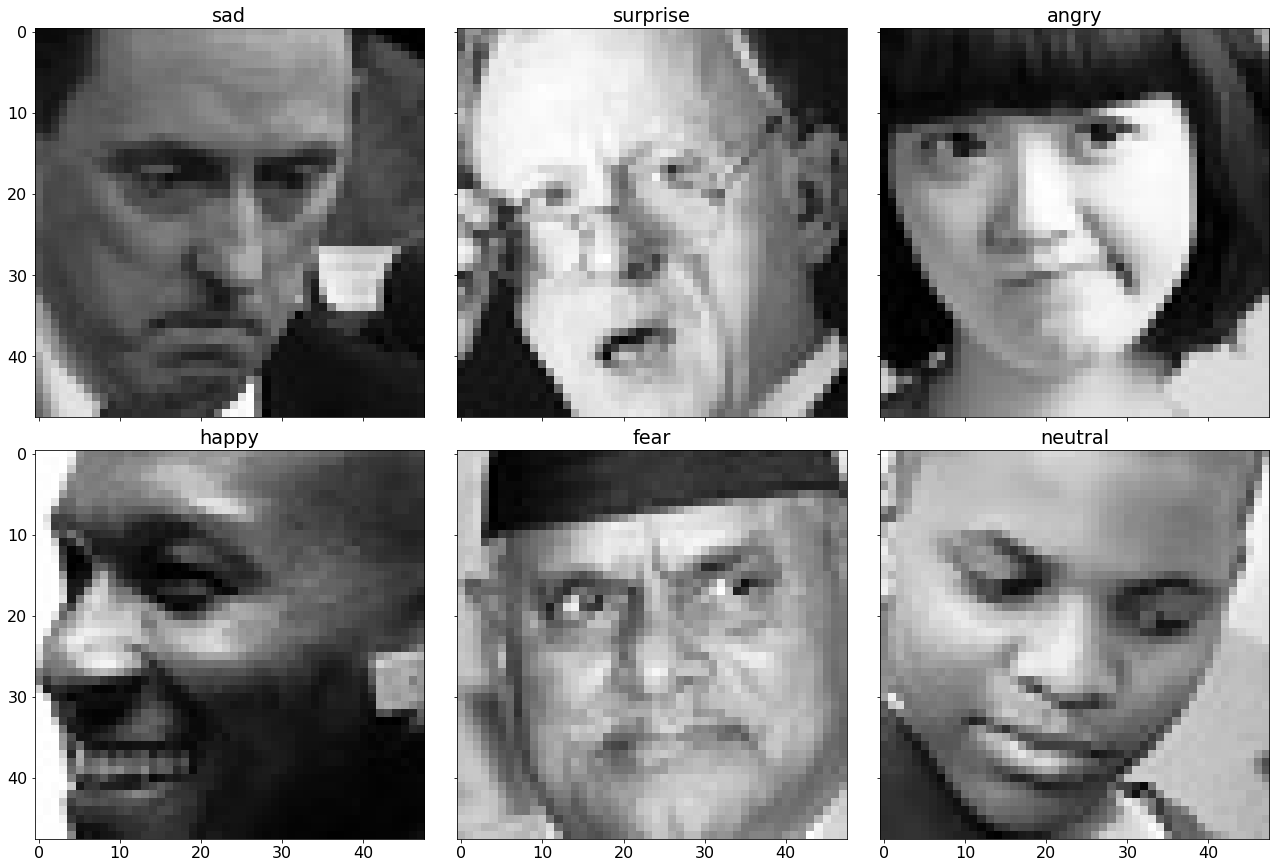

In [7]:
image_size = int(np.sqrt(feature_len))

fig, ax = plt.subplots(2, 3, sharex = True, sharey = True)
fig.set_size_inches(18, 12)
fig.tight_layout(pad = 0.5)
for i in range(n_class):
  ax[i//3][i%3].imshow(np.array(s_df[s_df.iloc[:,0] == i].iloc[i, 1:]*255).reshape(image_size, image_size), cmap = 'Greys')
  ax[i//3][i%3].set_title(CL[i])

plt.show()

## Split the data into training (80%) and test (20%) set for each class and combine.

In [8]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.DataFrame()
y_test = pd.DataFrame()

for i in range(n_class):
  # Split the data of each class into features (X) and response variable (y).
  globals()["CL"+str(i)+"_y"] = s_df[s_df.iloc[:,0] == i].iloc[:, 0]
  globals()["CL"+str(i)+"_X"] = s_df[s_df.iloc[:,0] == i].iloc[:, 1:]

  # Split each class to 80% of training set and 20% of test set.
  globals()["CL"+str(i)+"_X_train"], globals()["CL"+str(i)+"_X_test"], globals()["CL"+str(i)+"_y_train"], globals()["CL"+str(i)+"_y_test"] = train_test_split(globals()["CL"+str(i)+"_X"], globals()["CL"+str(i)+"_y"], test_size = 0.2, random_state = seed + i)
  
  X_train = pd.concat([X_train, globals()["CL"+str(i)+"_X_train"]])
  X_test = pd.concat([X_test, globals()["CL"+str(i)+"_X_test"]])
  y_train = pd.concat([y_train, globals()["CL"+str(i)+"_y_train"]])
  y_test = pd.concat([y_test, globals()["CL"+str(i)+"_y_test"]])

In [9]:
# Shuffle the training and test set
training = pd.concat([y_train, X_train], axis = 1).sample(frac = 1, random_state = seed)
y_train = training.iloc[:, 0]
X_train = training.iloc[:, 1:]

test = pd.concat([y_test, X_test], axis = 1)
test = test.sample(frac = 1, random_state = seed)
y_test = test.iloc[:, 0]
X_test = test.iloc[:, 1:]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train.values
X_test = X_test.values

y_train = to_categorical(y_train, n_class)
y_test = to_categorical(y_test, n_class)

Use 80-20 split method will give 22617 training cases and 5656 test cases.

## Define the function for Multilayer Perceptron (MLP) classifier

Input:
1. Optimizer
2. Activation Function
3. Size of input feature
4. Number of hidden layer
5. Neuron of neuron of each hidden layer
6. Batch Size
7. Number of Epochs
8. Feature of Training Set
9. True label of Training Set
10. Feautre of Test Set
11. True label of Test Set

Output:
1. Average Cross Entropy of Training Set for each batch
2. Average Cross Entropy of Test Set for each batch
3. Weights and Bias for each epoch
4. Computational Time
5. Trained Model
6. Overall Accuracy of Training Set for each epoch
7. Overall Accuracy of Test Set for each epoch

Note that
1. Loss Function is Categorical Cross Entropy and all the Categorical Cross Entropy is calculated based on entire training set and test set.
2. Activation function is ReLU except output layer which has SOFTMAX since it is a multiple classes classification task.
3. Optimizer is Adam.

In [10]:
def MLP_classifier(optimizer, activation, input_shape, layer_n, h, batch_size, epochs, X_train, y_train, X_test, y_test):
  trainloss_epoch, testloss_epoch, train_overall_acc_epoch, test_overall_acc_epoch, weights_epoch = [], [], [], [], {}

  # Model structure build up
  model = Sequential()
  model.add(Dense(h[0], input_shape = (input_shape,), activation = activation))
  if layer_n != 1:
    for i in range(1, layer_n):
      model.add(Dense(h[i], activation = activation))
  
  model.add(Dense(y_train.shape[1], activation = "softmax"))
  loss = tf.keras.losses.CategoricalCrossentropy()
  
  model.summary()
  
  start_time = time.time()
  for epoch in range(epochs):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size = 1024).batch(batch_size)
    # Iterate over the batches of the dataset.
    for batch, (x_batch_train, y_batch_train) in enumerate(train_dataset):
      # Open a GradientTape to record the operations run during the forward pass, which enables auto-differentiation.
      with tf.GradientTape() as tape:

          # Run the forward pass of the layer. The operations that the layer applies to its inputs are going to be recorded on the GradientTape.
          logit_train = model(x_batch_train, training = True)
          # Compute the loss value for this batch.
          loss_train = loss(y_batch_train, logit_train)

      # Use the gradient tape to automatically retrieve the gradients of the trainable variables with respect to the loss.
      grads = tape.gradient(loss_train, model.trainable_weights)
        
      # Run one batch of gradient descent by updating the value of the variables to minimize the loss.
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Compute the loss on entire training set after each epoch training.
    temp = model(X_train, training = False)
    loss_train_temp = loss(y_train, temp)
    trainloss_epoch.append(loss_train_temp.numpy())

    # Compute the overall accuracy on entire training set after each epoch training.
    train_overall_acc = round(np.mean(temp.numpy().argmax(axis = 1) == y_train.argmax(axis = 1))*100, 1)
    train_overall_acc_epoch.append(train_overall_acc)

    # Compute the loss on entire test set after each epoch training.
    temp = model(X_test, training = False)
    loss_test_temp = loss(y_test, temp)
    testloss_epoch.append(loss_test_temp.numpy())

    # Compute the overall accuracy on entire test set after each epoch training.
    test_overall_acc = round(np.mean(temp.numpy().argmax(axis = 1) == y_test.argmax(axis = 1))*100, 1)
    test_overall_acc_epoch.append(test_overall_acc)

    print("Epoch # %2d Finished.    Training Loss: %.4f (Overall Accuracy: %.1f%%)    Test Loss: %.4f (Overall Accuracy: %.1f%%)" %(epoch + 1, loss_train_temp.numpy(), train_overall_acc, loss_test_temp.numpy(), test_overall_acc))

    # Store the parameters after each epoch training.
    weights_epoch[epoch + 1] = model.get_weights()

  end_time = time.time()

  computing_time = round(end_time - start_time, 1)

  return (trainloss_epoch, testloss_epoch, weights_epoch, computing_time, model, train_overall_acc_epoch, test_overall_acc_epoch)

# Basic MLP classifier with one hidden layer (Total 3 layers)

Below shows the structure of the MLP classifier

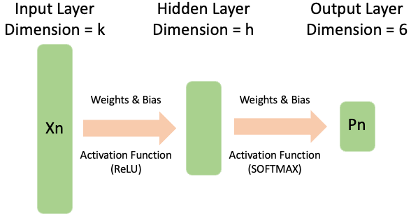

Model performance is measured by the AVerage of the CRoss Entropies (AVCRE) over each case, as well as the MLP estimate for probabilities (P(n)), for the training set and test set. The formulas are as below

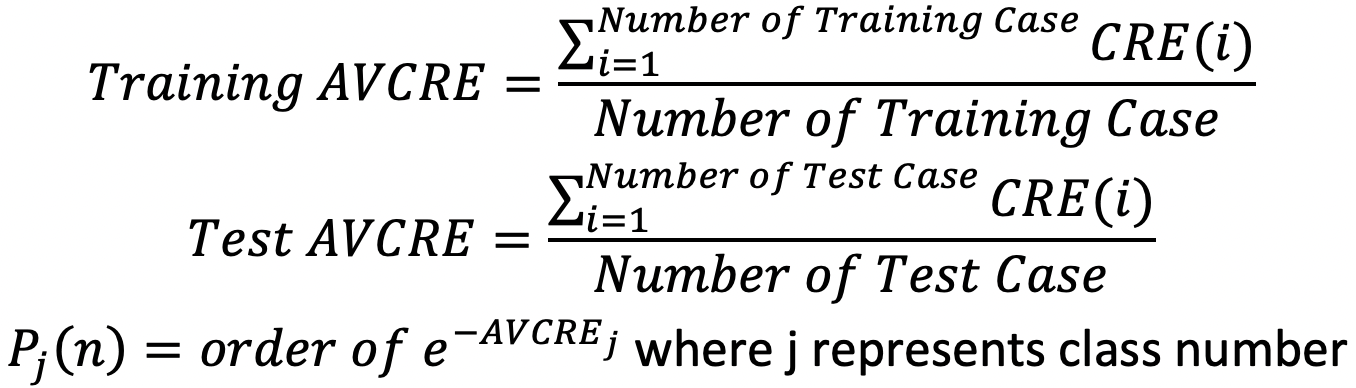

## Hyperparameters setting
1. Batch size = training set size / 50 = 452
2. Number of epoch = 10
3. Dimension of the hidden layer (h) = half of the feature number = 1152

In [11]:
tf.random.set_seed(seed)
MLP_h = MLP_classifier(tf.keras.optimizers.Adam(), "relu", feature_len, 1, [feature_len/2], int(X_train.shape[0]/50), 10, X_train, y_train, X_test, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1152)              2655360   
                                                                 
 dense_1 (Dense)             (None, 6)                 6918      
                                                                 
Total params: 2,662,278
Trainable params: 2,662,278
Non-trainable params: 0
_________________________________________________________________
Epoch #  1 Finished.    Training Loss: 1.7189 (Overall Accuracy: 31.2%)    Test Loss: 1.7243 (Overall Accuracy: 30.4%)
Epoch #  2 Finished.    Training Loss: 1.6748 (Overall Accuracy: 30.8%)    Test Loss: 1.6847 (Overall Accuracy: 30.1%)
Epoch #  3 Finished.    Training Loss: 1.7157 (Overall Accuracy: 27.2%)    Test Loss: 1.7279 (Overall Accuracy: 26.2%)
Epoch #  4 Finished.    Training Loss: 1.6122 (Overall Accuracy: 35.7%)    Test Loss:

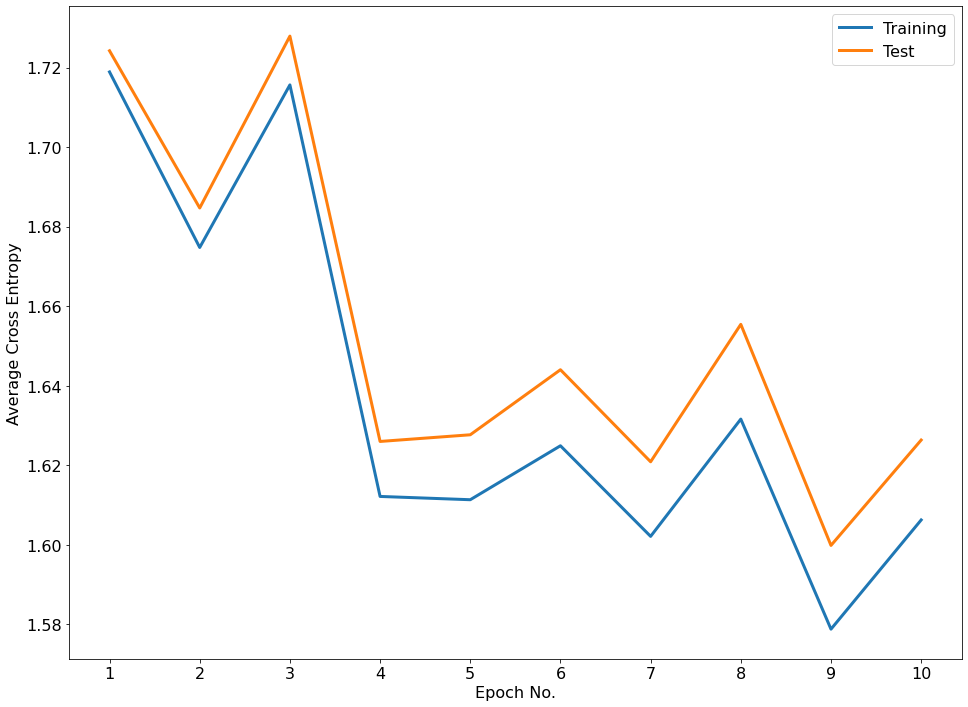

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (16, 12))
ax.plot(MLP_h[0], label = "Training", linewidth = 3)
ax.plot(MLP_h[1], label = "Test", linewidth = 3)
ax.set_xticks(range(0, 10))
ax.set_xticklabels(range(1, 11))
ax.set_xlabel("Epoch No.")
ax.set_ylabel("Average Cross Entropy")
ax.legend(loc = "upper right")
plt.show()

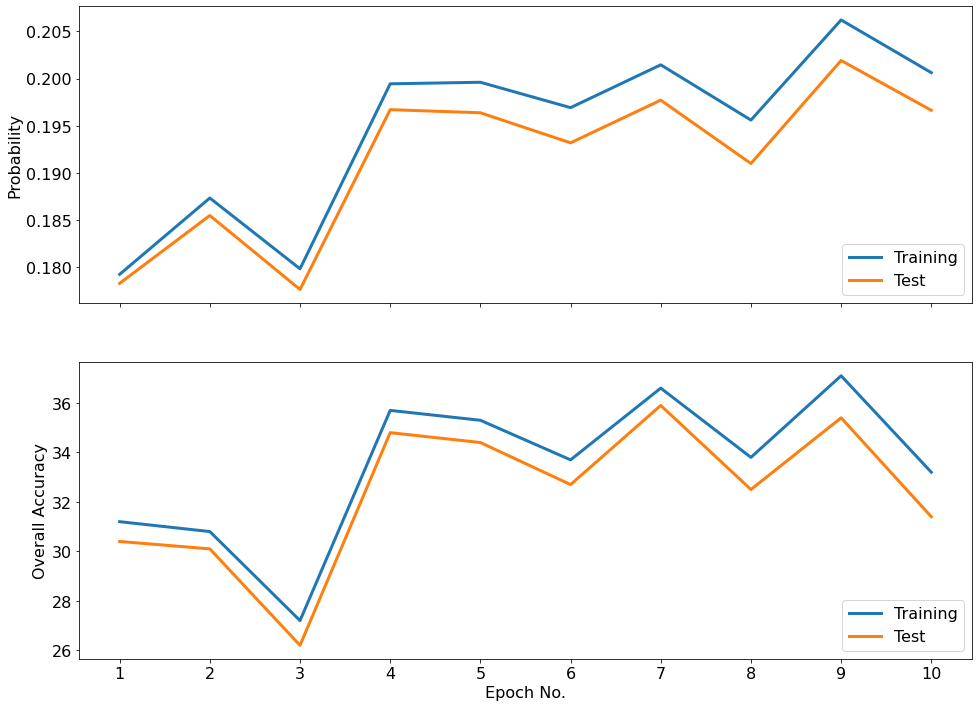

In [13]:
fig, ax = plt.subplots(2, 1, figsize = (16, 12), sharex = True)
ax[0].plot(np.exp(np.array(MLP_h[0])*-1), label = "Training", linewidth = 3)
ax[0].plot(np.exp(np.array(MLP_h[1])*-1), label = "Test", linewidth = 3)
ax[0].set_xticks(range(0, 10))
ax[0].set_xticklabels(range(1, 11))
# ax[0].set_xlabel("Epoch No.")
ax[0].set_ylabel("Probability")
ax[0].legend(loc = "lower right")

ax[1].plot(MLP_h[5], label = "Training", linewidth = 3)
ax[1].plot(MLP_h[6], label = "Test", linewidth = 3)
ax[1].set_xticks(range(0, 10))
ax[1].set_xticklabels(range(1, 11))
ax[1].set_xlabel("Epoch No.")
ax[1].set_ylabel("Overall Accuracy")
ax[1].legend(loc = "lower right")
plt.show()

The above two figures show that the initial model performs quite poorly. 

The Test AVCRE is around 1.6, which yield an expected probability close to 0.20. This is only slightly better than randomly guessing one of the 6 classes (0.167). The training set performance is not much better. 

It is noted that the trend of expected probability is similar to the trend of overall accuracy which makes the expected probability a good estimator for the model performance. 

### AVCRE over each class

In [14]:
avcre_training_class, avcre_test_class = [], []
for i in range(n_class):
  temp_training = MLP_h[4](globals()['CL'+ str(i) + '_X_train'].values, training = False)
  temp_test = MLP_h[4](globals()['CL'+ str(i) + '_X_test'].values, training = False)
  loss = tf.keras.losses.CategoricalCrossentropy()
  temp_loss_training = np.round(np.array(loss(to_categorical(globals()['CL'+ str(i) + '_y_train'], n_class), temp_training)), 3)
  avcre_training_class.append(temp_loss_training)
  temp_loss_test = np.round(np.array(loss(to_categorical(globals()['CL'+ str(i) + '_y_test'], n_class), temp_test)), 3)
  avcre_test_class.append(temp_loss_test)

avcre_class = pd.DataFrame({"Training AVCRE": avcre_training_class, "Test AVCRE": avcre_test_class}).transpose()
avcre_class

,0,1,2,3,4,5
Training AVCRE,1.825,1.574,1.952,1.547,1.704,1.142
Test AVCRE,1.862,1.609,1.996,1.545,1.713,1.157


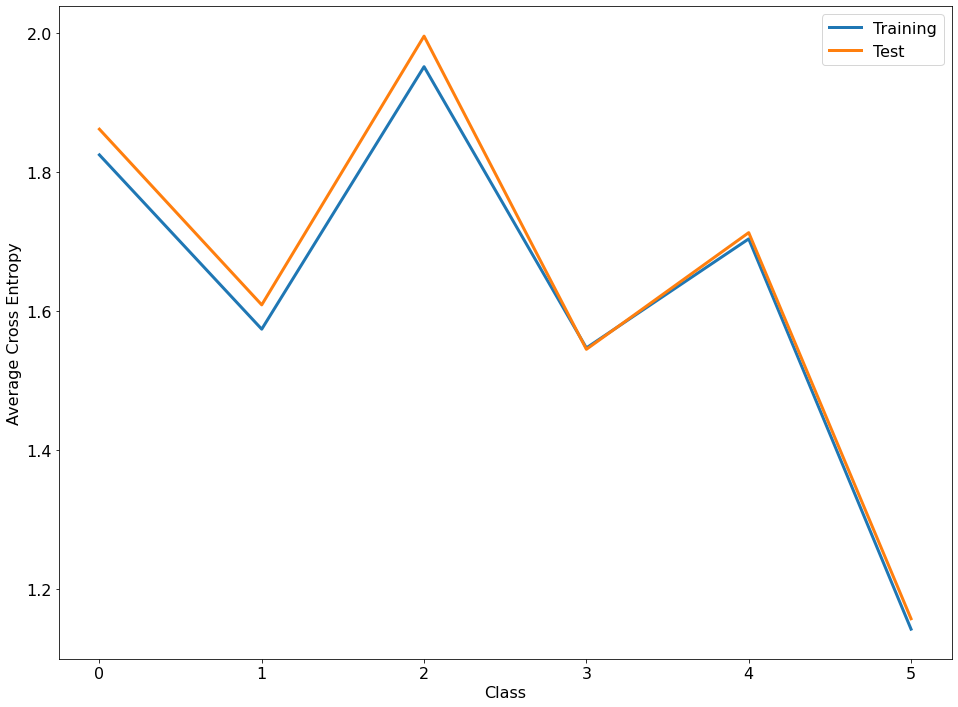

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (16, 12))
ax.plot(avcre_class.iloc[0,:], label = "Training", linewidth = 3)
ax.plot(avcre_class.iloc[1,:], label = "Test", linewidth = 3)
ax.set_xlabel("Class")
ax.set_ylabel("Average Cross Entropy")
ax.legend(loc = "upper right")
plt.show()

In [16]:
pn_class = np.round(np.exp(avcre_class*-1), 3)
pn_class.index = ["Training Pj", "Test Pj"]
pn_class

,0,1,2,3,4,5
Training Pj,0.161,0.207,0.142,0.213,0.182,0.319
Test Pj,0.155,0.200,0.136,0.213,0.180,0.314


The AVCRE table and Pj(n) table for each of the 6 classes are not impressive. 

The highest Pj(n) belongs to class 5, neutral, with 0.319 for the training set and 0.314 for the test set. Thus, it can be assumed that this model can predict the cases of class 5 more accurate. 

### Confusion Matrices

The confusion matrix of the training set and test set reveal that class 5’s relatively successful performance may only be due to the MLP obsession with classifying photos as neutral. 

However, there are a lot of cases in class 0 to 4 misclassified as class 5. 

In [17]:
y_train_pred_h = pd.DataFrame(np.array(MLP_h[4](X_train, training = False)), index = training.index).idxmax(axis = 1)
conf_matrix_training_h = round(pd.DataFrame(confusion_matrix(training.iloc[:,0], y_train_pred_h, normalize = "true", labels = range(n_class)))*100, 1)

conf_matrix_training_h.index.name = "True"
conf_matrix_training_h.columns.name = "Predicted"
conf_matrix_training_h

Predicted,0,1,2,3,4,5
True,,,,,,
0,9.9,4.6,2.9,10.0,8.4,64.4
1,1.9,48.0,1.4,7.0,8.2,33.4
2,4.7,8.0,7.1,13.9,9.9,56.5
3,4.0,4.2,2.2,37.1,4.8,47.7
4,5.0,14.8,3.5,10.8,12.1,53.8
5,2.7,5.0,1.7,7.2,4.3,79.1


In [18]:
print("Overall Accuracy for Training Set: %.1f%% " % round(np.mean(y_train_pred_h == training.iloc[:,0])*100, 1))

Overall Accuracy for Training Set: 33.2% 


In [19]:
y_test_pred_h = pd.DataFrame(np.array(MLP_h[4](X_test, training = False)), index = test.index).idxmax(axis = 1)
conf_matrix_test_h = round(pd.DataFrame(confusion_matrix(test.iloc[:,0], y_test_pred_h, normalize = "true", labels = range(n_class)))*100, 1)

conf_matrix_test_h.index.name = "True"
conf_matrix_test_h.columns.name = "Predicted"
conf_matrix_test_h

Predicted,0,1,2,3,4,5
True,,,,,,
0,8.4,4.8,4.5,10.5,9.0,62.9
1,1.3,43.5,2.4,8.3,7.4,37.2
2,3.6,8.0,5.6,13.8,10.1,58.8
3,4.3,3.7,2.9,37.1,4.4,47.6
4,6.7,14.8,3.0,9.6,10.6,55.2
5,4.4,4.2,1.7,8.9,5.0,75.7


In [20]:
print("Overall Accuracy for Test Set: %.1f%%" % round(np.mean(y_test_pred_h == test.iloc[:,0])*100, 1))

Overall Accuracy for Test Set: 31.4%


In addition, since the number of hidden layer neuron is set to be half of the number of features, it can be foreseen that the model learning process will be time-consuming due to the large number of parameters.

In [21]:
print("Computing Time: %.1fs." % MLP_h[3])

Computing Time: 113.6s.


# MLP with lower value of number of hidden layer neuron

Because the number of hidden layer neuron is highly related to the number of parameters and computational time, it is wise to check if it is possible to reduce it but keep the performance as high as possible. 

A possible new number of neurons in the hidden layer can be obtained by principal component analysis of the training set, Xn. 

The new dimension of the hidden layer, h_low, is such to where h_low = the number of principal components that give 90% of explained variance of input features. 

In [22]:
# Standardize the data
SS = StandardScaler().fit(training.iloc[:, 1:])
c_r_X = pd.DataFrame(SS.transform(training.iloc[:, 1:]))

# PCA Analysis
pca_h_low = PCA()
pca_h_low.fit_transform(c_r_X)
PEV_h_low = pca_h_low.explained_variance_ratio_.cumsum()*100
h_low = sum(PEV_h_low < 90) + 1
h_low

114


The dimension of the hidden layer of our new model will be h_low  = 114. Below figure shows the Percentage of Explained Variance (PEV) versus the number of principal component for entire training set. 

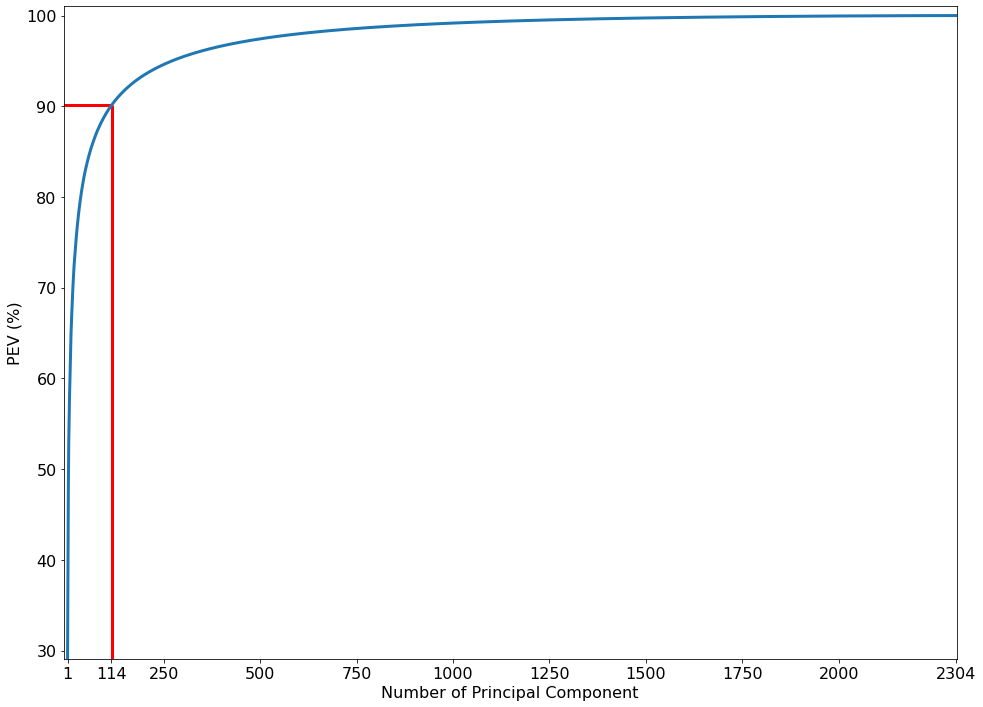

In [23]:
fig, ax = plt.subplots(1, 1)
ax.plot(PEV_h_low, lw = 3)
ax.vlines(h_low, PEV_h_low[0] , PEV_h_low[h_low], color = "r", lw = 3)
ax.hlines(PEV_h_low[h_low], -100, h_low, color = "r", lw = 3)
ax.set_xlim([-10, len(PEV_h_low)])
ax.set_ylim([PEV_h_low[0], 101])
ax.set_xlabel("Number of Principal Component")
ax.set_ylabel("PEV (%)")
ax.set_xticks([0, h_low - 1, 249, 499, 749, 999, 1249, 1499, 1749, 1999, feature_len-1])
ax.set_xticklabels([1, h_low, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, feature_len])
plt.show()

### Retrain model with number of hidden layer neuron = h_low

The performance of the new model, MLP_low, is not drastically improved from the original model in previous section. Test accuracies have only improved by a few percent while comparing the result with epoch number less than 10. 

Noted that number of epoch has increased to 50 for better understanding.

In [24]:
tf.random.set_seed(seed)
MLP_h_low = MLP_classifier(tf.keras.optimizers.Adam(), "relu", feature_len, 1, [h_low], 100, 50, X_train, y_train, X_test, y_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 114)               262770    
                                                                 
 dense_3 (Dense)             (None, 6)                 690       
                                                                 
Total params: 263,460
Trainable params: 263,460
Non-trainable params: 0
_________________________________________________________________
Epoch #  1 Finished.    Training Loss: 1.6970 (Overall Accuracy: 27.4%)    Test Loss: 1.7069 (Overall Accuracy: 26.6%)
Epoch #  2 Finished.    Training Loss: 1.6432 (Overall Accuracy: 32.4%)    Test Loss: 1.6598 (Overall Accuracy: 30.9%)
Epoch #  3 Finished.    Training Loss: 1.6109 (Overall Accuracy: 35.7%)    Test Loss: 1.6282 (Overall Accuracy: 34.5%)
Epoch #  4 Finished.    Training Loss: 1.5866 (Overall Accuracy: 37.1%)    Test Loss: 1

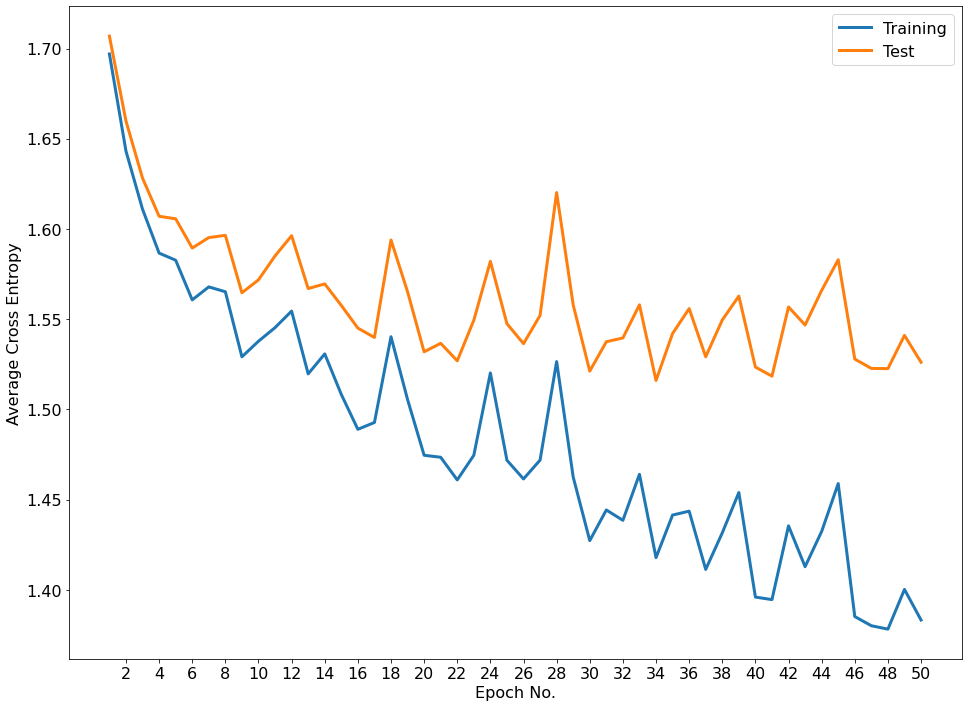

In [25]:
fig, ax = plt.subplots(1, 1)
ax.plot(MLP_h_low[0], label = "Training", linewidth = 3)
ax.plot(MLP_h_low[1], label = "Test", linewidth = 3)
ax.set_xticks(range(1, 51, 2))
ax.set_xticklabels(range(2, 52, 2))
ax.set_xlabel("Epoch No.")
ax.set_ylabel("Average Cross Entropy")
ax.legend(loc = "upper right")
plt.show()

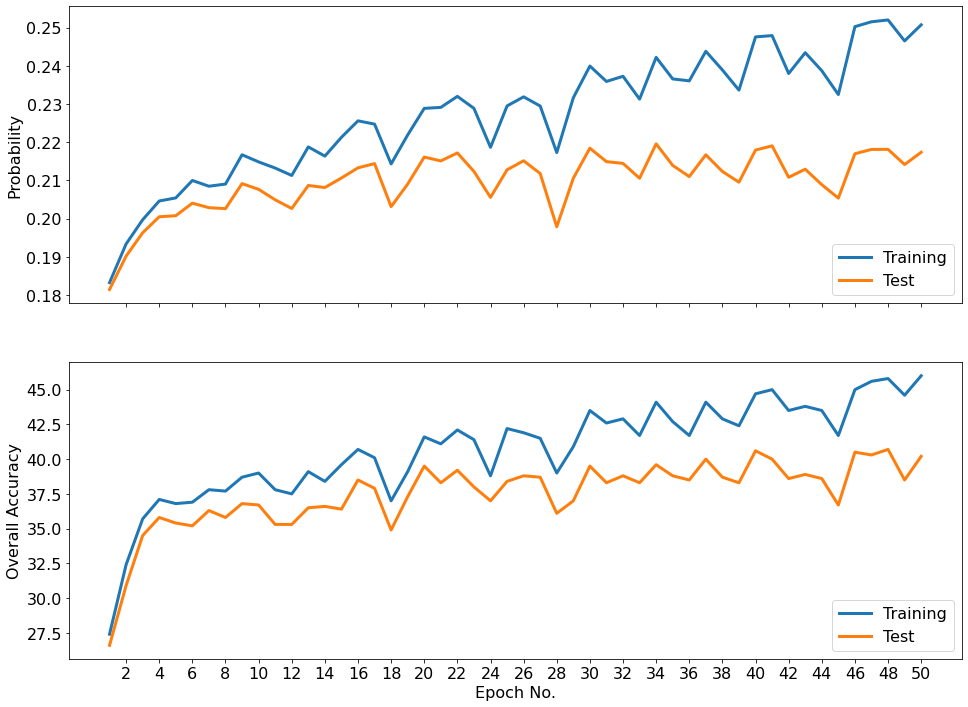

In [26]:
fig, ax = plt.subplots(2, 1, sharex = True)
ax[0].plot(np.exp(np.array(MLP_h_low[0])*-1), label = "Training", linewidth = 3)
ax[0].plot(np.exp(np.array(MLP_h_low[1])*-1), label = "Test", linewidth = 3)
ax[0].set_xticks(range(1, 51, 2))
ax[0].set_xticklabels(range(2, 52, 2))
# ax[0].set_xlabel("Epoch No.")
ax[0].set_ylabel("Probability")
ax[0].legend(loc = "lower right")

ax[1].plot(MLP_h_low[5], label = "Training", linewidth = 3)
ax[1].plot(MLP_h_low[6], label = "Test", linewidth = 3)
ax[1].set_xticks(range(1, 51, 2))
ax[1].set_xticklabels(range(2, 52, 2))
ax[1].set_xlabel("Epoch No.")
ax[1].set_ylabel("Overall Accuracy")
ax[1].legend(loc = "lower right")
plt.show()

It appears that increasing the number of epochs does more to improve AVCRE and Pj(n) than changing the number of neurons in the hidden layer.

## Stopping Epoch Evaluation

In order to stop the learning at a reasonable time, there are 4 essential criteria for selecting a good stopping epoch as below.
1.     StabTrain
> * Epoch of stabilization for Training AVCREm
> * Improvement of Training AVCREm should be small for m > StabTrain 
2.     MinTest
> * Epoch when Test AVCREm reaches a global minimum
> * Test AVCREm starts roughly increasing for most m > MinTest 
3.     SafeZone
> * All epochs such that Test AVCREm > Training AVCREm
> * This is the zone of no overfitting.
4.     SafeMinTest
> * Epoch m* in SafeZone 
>> 1. where Test AVCREm reaches its minimum on SafeZone
>> 2. starts increasing on SafeZone 
> * m* is often a good mSTOP, but compare it to StabTrain

As per Figure 6, the criteria mentioned above can be detailed explained .
1. StabTrain:  In our case, the Training AVCREm will keep decreasing as the epoch number goes larger (even m > 50).
2. MinTest: After epoch > 22, the Test AVCREm curve become flatter and doesn’t improve a lot as the epoch number goes higher. 
3. SafeZone: It is always true that Test AVCREm > Training AVCREm. Thus, the entire learning process can be viewed as SafeZone.
4. SafeMinTest: Thus, the selection of epoch = 22 seems to be a good stopping epoch number.


## MLP_low stop at a good epoch (stopping epoch m*)

The MLP_low model will be retrained and stop at epoch number = 22 to extract the corresponding weights and biases.

In [27]:
stopping_m_low = 22
tf.random.set_seed(seed)
MLP_h_low_stopping_m = MLP_classifier(tf.keras.optimizers.Adam(), "relu", feature_len, 1, [h_low], 100, stopping_m_low, X_train, y_train, X_test, y_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 114)               262770    
                                                                 
 dense_5 (Dense)             (None, 6)                 690       
                                                                 
Total params: 263,460
Trainable params: 263,460
Non-trainable params: 0
_________________________________________________________________
Epoch #  1 Finished.    Training Loss: 1.6970 (Overall Accuracy: 27.4%)    Test Loss: 1.7069 (Overall Accuracy: 26.6%)
Epoch #  2 Finished.    Training Loss: 1.6432 (Overall Accuracy: 32.4%)    Test Loss: 1.6598 (Overall Accuracy: 30.9%)
Epoch #  3 Finished.    Training Loss: 1.6109 (Overall Accuracy: 35.7%)    Test Loss: 1.6282 (Overall Accuracy: 34.5%)
Epoch #  4 Finished.    Training Loss: 1.5866 (Overall Accuracy: 37.1%)    Test Loss: 1

### Confusion Matrices with Stopping Epoch m*

It can be observed that cases misclassified to class 5 are lower than the orignial model, MLP. 

However, more cases are misclassified to class 3 for MLP_low. Comparing to the overall accuracy for both training and test set with those for MLP, they have individually increased around 10% which is a huge improvement.

In [28]:
y_train_pred_h_low_stopping_m = pd.DataFrame(np.array(MLP_h_low_stopping_m[4](X_train, training = False)), index = training.index).idxmax(axis = 1)
conf_matrix_training_h_low_stopping_m = round(pd.DataFrame(confusion_matrix(training.iloc[:,0], y_train_pred_h_low_stopping_m, normalize = "true", labels = range(n_class)))*100, 1)

conf_matrix_training_h_low_stopping_m.index.name = "True"
conf_matrix_training_h_low_stopping_m.columns.name = "Predicted"
conf_matrix_training_h_low_stopping_m

Predicted,0,1,2,3,4,5
True,,,,,,
0,25.4,5.7,16.2,21.1,3.9,27.7
1,5.0,57.6,6.7,14.0,3.6,13.2
2,11.6,7.6,33.7,21.9,3.7,21.4
3,7.7,4.1,8.5,65.8,1.5,12.3
4,13.8,16.9,16.4,22.0,8.9,22.0
5,10.7,6.5,10.0,22.4,2.5,48.0


In [29]:
print("Overall Accuracy for Training Set: %.1f%%" % round(np.mean(y_train_pred_h_low_stopping_m == training.iloc[:,0])*100, 1))

Overall Accuracy for Training Set: 42.1%


In [30]:
y_test_pred_h_low_stopping_m = pd.DataFrame(np.array(MLP_h_low_stopping_m[4](X_test, training = False)), index = test.index).idxmax(axis = 1)
conf_matrix_test_h_low_stopping_m = round(pd.DataFrame(confusion_matrix(test.iloc[:,0], y_test_pred_h_low_stopping_m, normalize = "true", labels = range(n_class)))*100, 1)

conf_matrix_test_h_low_stopping_m.index.name = "True"
conf_matrix_test_h_low_stopping_m.columns.name = "Predicted"
conf_matrix_test_h_low_stopping_m

Predicted,0,1,2,3,4,5
True,,,,,,
0,22.5,5.9,19.3,21.2,3.1,28.1
1,4.6,53.1,5.8,18.3,3.6,14.6
2,11.1,8.1,30.2,22.2,3.4,25.0
3,7.1,4.2,10.5,63.8,1.5,13.0
4,15.9,17.4,19.1,21.8,5.9,19.9
5,11.1,6.4,9.9,23.2,3.9,45.5


In [31]:
print("Overall Accuracy for Test Set: %.1f%%" % round(np.mean(y_test_pred_h_low_stopping_m == test.iloc[:,0])*100, 1))

Overall Accuracy for Test Set: 39.2%


The computing time to finish the learning (number of epoch = 22) is similar to the result of original model (number of epoch = 10) which means that computational time per epoch is decreased as number of hidden layer neuron decrease.

This is reasonable since the total number of parameter is decreased.

In [32]:
print("Computing Time: %.1fs." % MLP_h_low_stopping_m[3])

Computing Time: 121.0s.


# MLP with higher value of number of hidden layer neuron

A new dimension of the hidden layer, h_high, is used to create the third MLP, MLP_high. 

h_high is the sum of all hj, where hj is the number of principal components that explain 90% of the variance in each class.

In [33]:
h_high = 0
for i in range(n_class):
  # Standardize the data
  temp = training[training.iloc[:, 0] == i].iloc[:, 1:]
  SS = StandardScaler().fit(temp)
  c_r_temp = pd.DataFrame(SS.transform(temp))

  # PCA Analysis
  globals()["pca_h_"+str(i)] = PCA()
  globals()["pca_h_"+str(i)].fit_transform(c_r_temp)
  globals()["PEV_h_"+str(i)] = globals()["pca_h_"+str(i)].explained_variance_ratio_.cumsum()*100
  globals()["h_"+str(i)] = sum(globals()["PEV_h_"+str(i)] < 90) + 1
  h_high += globals()["h_"+str(i)]

h_high

650

Below figure shows the PEV versus the number of principal component for each class.

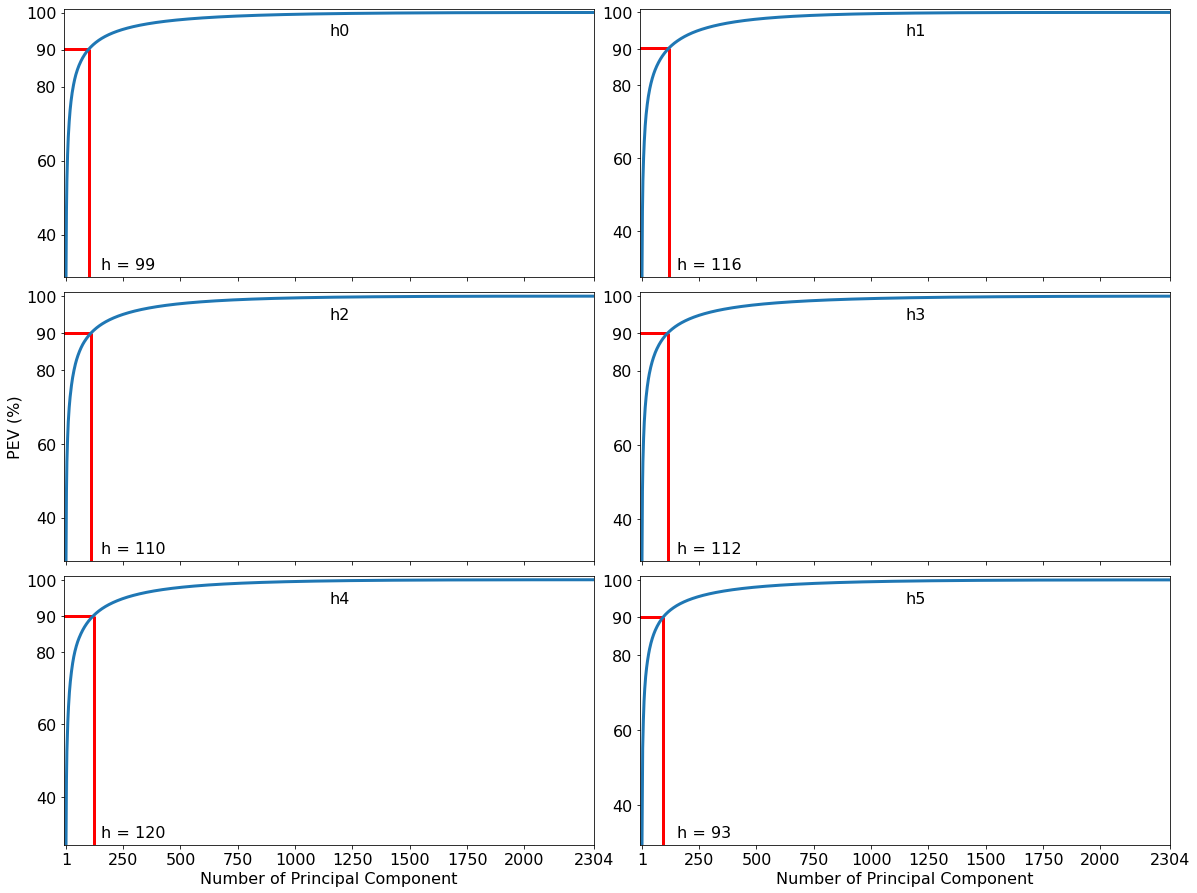

In [34]:
fig, ax = plt.subplots(3, 2, sharex = True)

fig.set_size_inches(16, 12)
fig.tight_layout(pad = 0)

for i in range(n_class):
  temp_h = globals()["h_"+str(i)]
  temp_PEV = globals()["PEV_h_"+str(i)]
  ax[i//2][i%2].plot(temp_PEV, lw = 3)
  ax[i//2][i%2].vlines(temp_h, temp_PEV[0] , temp_PEV[temp_h], color = "r", lw = 3)
  ax[i//2][i%2].hlines(temp_PEV[temp_h], -100, temp_h, color = "r", lw = 3)
  ax[i//2][i%2].set_xlim([-10, len(temp_PEV)])
  ax[i//2][i%2].set_ylim([temp_PEV[0], 101])
  ax[i//2][i%2].set_xticks([0, 249, 499, 749, 999, 1249, 1499, 1749, 1999, feature_len-1])
  ax[i//2][i%2].set_xticklabels([1, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, feature_len])
  ax[i//2][i%2].set_yticks([40, 60, 80, 90, 100])
  # ax[i//2][i%2].set_yticklabels([1, temp_h, 500, 1000, 1500, 2000])
  ax[i//2][i%2].text(0.07, 0.03, "h = " + str(temp_h), transform = ax[i//2][i%2].transAxes, ha = "left")
  ax[i//2][i%2].text(0.5, 0.9, "h" + str(i), transform = ax[i//2][i%2].transAxes, ha = "left")

ax[1][0].set_ylabel("PEV (%)")
ax[2][0].set_xlabel("Number of Principal Component")
ax[2][1].set_xlabel("Number of Principal Component")

plt.show()

The dimension of the hidden layer of MLP_high is h_high = 650.

## Retrain model with number of hidden layer neuron = h_high

The performance of MLP_high with h = h_high = 650 is not drastically improved comparing to the MLP_low with h = h_low = 114.

In [35]:
tf.random.set_seed(seed)
MLP_h_high = MLP_classifier(tf.keras.optimizers.Adam(), "relu", feature_len, 1, [h_high], 100, 50, X_train, y_train, X_test, y_test)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 650)               1498250   
                                                                 
 dense_7 (Dense)             (None, 6)                 3906      
                                                                 
Total params: 1,502,156
Trainable params: 1,502,156
Non-trainable params: 0
_________________________________________________________________
Epoch #  1 Finished.    Training Loss: 1.6825 (Overall Accuracy: 27.8%)    Test Loss: 1.6927 (Overall Accuracy: 26.8%)
Epoch #  2 Finished.    Training Loss: 1.6175 (Overall Accuracy: 35.4%)    Test Loss: 1.6343 (Overall Accuracy: 34.1%)
Epoch #  3 Finished.    Training Loss: 1.6190 (Overall Accuracy: 33.0%)    Test Loss: 1.6359 (Overall Accuracy: 31.6%)
Epoch #  4 Finished.    Training Loss: 1.5670 (Overall Accuracy: 36.8%)    Test Los

From figures below, Training and Test accuracies for MLP_high are almost same as those for MLP_low. It appears that increasing the number of hidden layer neuron doesn’t improve the performance to an astonished level. 

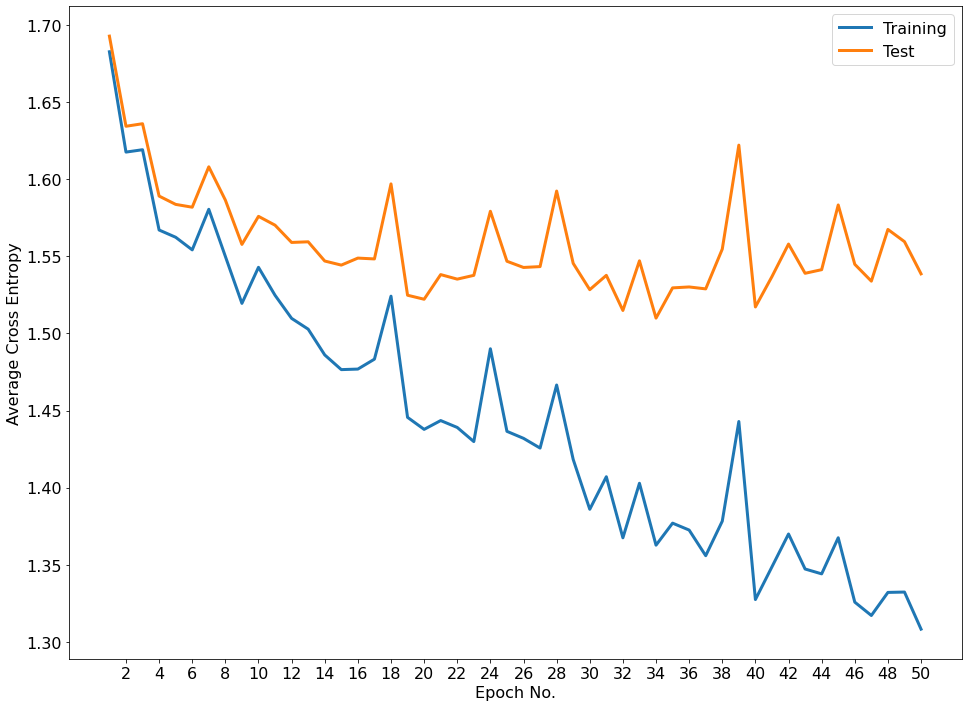

In [36]:
fig, ax = plt.subplots(1, 1)
ax.plot(MLP_h_high[0], label = "Training", linewidth = 3)
ax.plot(MLP_h_high[1], label = "Test", linewidth = 3)
ax.set_xticks(range(1, 51, 2))
ax.set_xticklabels(range(2, 52, 2))
ax.set_xlabel("Epoch No.")
ax.set_ylabel("Average Cross Entropy")
ax.legend(loc = "upper right")
plt.show()

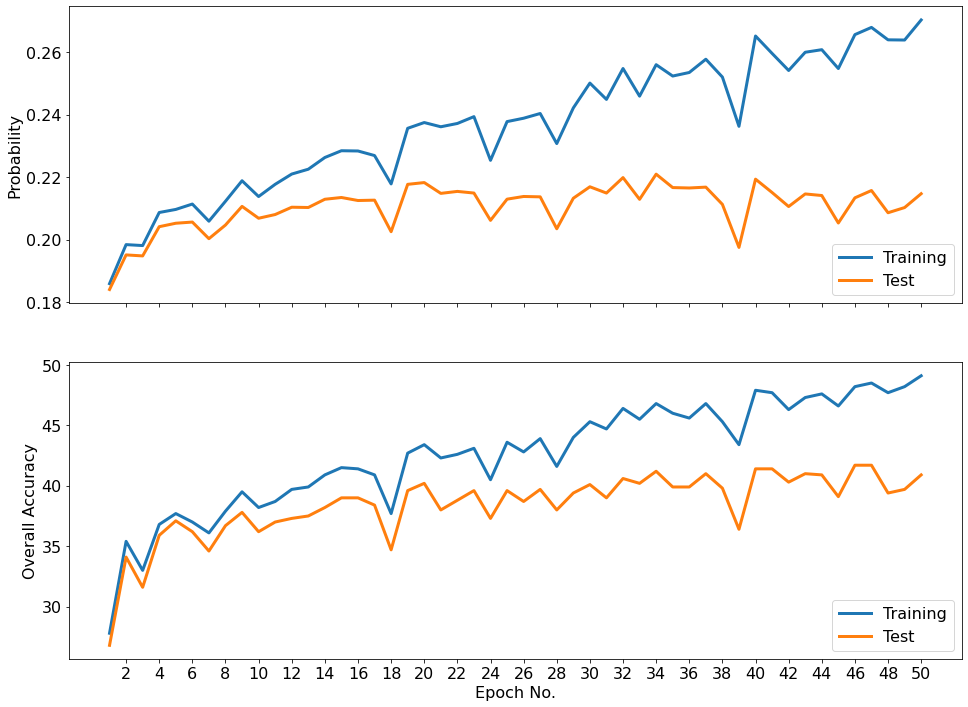

In [37]:
fig, ax = plt.subplots(2, 1, sharex = True)
ax[0].plot(np.exp(np.array(MLP_h_high[0])*-1), label = "Training", linewidth = 3)
ax[0].plot(np.exp(np.array(MLP_h_high[1])*-1), label = "Test", linewidth = 3)
ax[0].set_xticks(range(1, 51, 2))
ax[0].set_xticklabels(range(2, 52, 2))
# ax[0].set_xlabel("Epoch No.")
ax[0].set_ylabel("Probability")
ax[0].legend(loc = "lower right")

ax[1].plot(MLP_h_high[5], label = "Training", linewidth = 3)
ax[1].plot(MLP_h_high[6], label = "Test", linewidth = 3)
ax[1].set_xticks(range(1, 51, 2))
ax[1].set_xticklabels(range(2, 52, 2))
ax[1].set_xlabel("Epoch No.")
ax[1].set_ylabel("Overall Accuracy")
ax[1].legend(loc = "lower right")
plt.show()

Since the trend of both Training AVCREm and Test AVCREm are very similar to MLP_low, it can be concluded that the selection of epoch = 22 seems to be a good stopping epoch number for MLP_high as well. 

## MLP_high stop at a good epoch (stopping epoch m*)

The MLP_high model will be retrained and stop at epoch number = 22 to extract the corresponding weights and biases.

In [38]:
stopping_m_high = 22
tf.random.set_seed(seed)
MLP_h_high_stopping_m = MLP_classifier(tf.keras.optimizers.Adam(), "relu", feature_len, 1, [h_high], 100, stopping_m_high, X_train, y_train, X_test, y_test)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 650)               1498250   
                                                                 
 dense_9 (Dense)             (None, 6)                 3906      
                                                                 
Total params: 1,502,156
Trainable params: 1,502,156
Non-trainable params: 0
_________________________________________________________________
Epoch #  1 Finished.    Training Loss: 1.6825 (Overall Accuracy: 27.8%)    Test Loss: 1.6927 (Overall Accuracy: 26.8%)
Epoch #  2 Finished.    Training Loss: 1.6175 (Overall Accuracy: 35.4%)    Test Loss: 1.6343 (Overall Accuracy: 34.1%)
Epoch #  3 Finished.    Training Loss: 1.6190 (Overall Accuracy: 33.0%)    Test Loss: 1.6359 (Overall Accuracy: 31.6%)
Epoch #  4 Finished.    Training Loss: 1.5670 (Overall Accuracy: 36.8%)    Test Los

### Confusion Matrices with Stopping Epoch m*

Below two tablea show the confusion matricrs of the training and test set respectively for MLP_high at epoch number = 22. 

It can be observed that cases misclassified to class 3 are lower than those for MLP_low. 

However, more cases are misclassified to class 0 for MLP_high model. Also, the overall accuracies don’t increase compared to MLP_low. 

In [39]:
y_train_pred_h_high_stopping_m = pd.DataFrame(np.array(MLP_h_high_stopping_m[4](X_train, training = False)), index = training.index).idxmax(axis = 1)
conf_matrix_training_h_high_stopping_m = round(pd.DataFrame(confusion_matrix(training.iloc[:,0], y_train_pred_h_high_stopping_m, normalize = "true", labels = range(n_class)))*100, 1)

conf_matrix_training_h_high_stopping_m.index.name = "True"
conf_matrix_training_h_high_stopping_m.columns.name = "Predicted"
conf_matrix_training_h_high_stopping_m

Predicted,0,1,2,3,4,5
True,,,,,,
0,55.3,4.6,10.5,14.6,5.4,9.6
1,13.6,57.3,5.2,11.3,7.1,5.6
2,34.1,6.2,29.8,16.8,6.0,7.1
3,20.2,2.8,7.5,61.8,3.3,4.3
4,32.5,14.3,12.1,15.3,16.4,9.3
5,35.8,6.4,9.3,18.7,5.0,24.9


In [40]:
print("Overall Accuracy for Training Set: %.1f%%" % round(np.mean(y_train_pred_h_high_stopping_m == training.iloc[:,0])*100, 1))

Overall Accuracy for Training Set: 42.6%


In [41]:
y_test_pred_h_high_stopping_m = pd.DataFrame(np.array(MLP_h_high_stopping_m[4](X_test, training = False)), index = test.index).idxmax(axis = 1)
conf_matrix_test_h_high_stopping_m = round(pd.DataFrame(confusion_matrix(test.iloc[:,0], y_test_pred_h_high_stopping_m, normalize = "true", labels = range(n_class)))*100, 1)

conf_matrix_test_h_high_stopping_m.index.name = "True"
conf_matrix_test_h_high_stopping_m.columns.name = "Predicted"
conf_matrix_test_h_high_stopping_m

Predicted,0,1,2,3,4,5
True,,,,,,
0,50.1,5.3,11.5,16.0,6.6,10.5
1,15.1,52.8,4.4,14.5,6.1,7.1
2,32.3,7.0,26.8,17.1,7.4,9.4
3,21.1,3.8,8.2,58.4,3.7,4.8
4,36.3,15.0,13.3,15.5,11.8,8.0
5,34.3,5.8,11.0,20.7,5.8,22.3


In [42]:
print("Overall Accuracy for Test Set: %.1f%%" % round(np.mean(y_test_pred_h_high_stopping_m == test.iloc[:,0])*100, 1))

Overall Accuracy for Test Set: 38.8%


The computing time to finish the learning of MLP_high is much more than the timing required by MLP_low. 

However, it is reasonable since the total number of parameters is larger. 

In [43]:
print("Computing Time: %.1fs." % MLP_h_high_stopping_m[3])

Computing Time: 233.3s.


# AutoEncoder

An AutoEncoder was developed to reduce the required storage capacity and improve the MLP model. 

The AutoEncoder encodes and decodes Zn. Zn is the output of MLP_high’s hidden layer and is of dimension h_high. 

Encoding Zn creates the vector Kn on layer L_2. The dimension of Kn / the number of neurons in L_2, h_2, is determined by the number of principal components that explain 95% of the variance of Zn. h_2 = 26. 

Decoding Kn on layer L_3 creates the vector Z’n. Z’n has the same dimension, hhigh, and should be close in value to Zn.

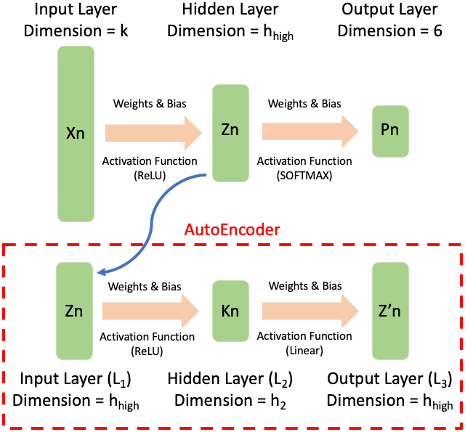

## Define the function for AutoEncoder
Input:
1. Optimizer
2. Activation Function
3. Size of input feature
4. Number of hidden layer
5. Batch Size
6. Number of Epochs
7. Feature of Training Set
8. Feautre of Test Set

Output:
1. MSE of Training Set for each batch
2. MSE of Test Set for each batch
3. Weights and Bias for each epoch
4. Computational Time
5. Trained Model

Note that
1. Loss Function is MSE and all the MSE is calculated based on entire training set and test set.
2. Activation function is ReLU.
3. Optimizer is Adam.

In [44]:
def AutoEncoder(optimizer, activation, input_shape, h, batch_size, epochs, X_train, X_test):
  trainloss_epoch, testloss_epoch, weights_epoch = [], [], {}
  
  # Model structure build up
  model = Sequential()
  model.add(Dense(h, input_shape = (input_shape,), activation = activation))
  model.add(Dense(input_shape, activation = 'linear'))
  loss = tf.keras.losses.MeanSquaredError()
  model.summary()
  
  start_time = time.time()
  for epoch in range(epochs):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, X_train)).shuffle(buffer_size = 1024).batch(batch_size)
    # Iterate over the batches of the dataset.
    for batch, (x_batch_train, y_batch_train) in enumerate(train_dataset):
      # Open a GradientTape to record the operations run during the forward pass, which enables auto-differentiation.
      with tf.GradientTape() as tape:

          # Run the forward pass of the layer. The operations that the layer applies to its inputs are going to be recorded on the GradientTape.
          logit_train = model(x_batch_train, training = True)
          # Compute the loss value for this batch.
          loss_train = loss(y_batch_train, logit_train)

      # Use the gradient tape to automatically retrieve the gradients of the trainable variables with respect to the loss.
      grads = tape.gradient(loss_train, model.trainable_weights)
        
      # Run one batch of gradient descent by updating the value of the variables to minimize the loss.
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Compute the loss on entire training set after each epoch training.
    temp = model(X_train, training = False)
    loss_train_temp = loss(X_train, temp)
    trainloss_epoch.append(loss_train_temp.numpy())

    # Compute the loss on entire test set after each epoch training.
    temp = model(X_test, training = False)
    loss_test_temp = loss(X_test, temp)
    testloss_epoch.append(loss_test_temp.numpy())

    print("Epoch # %2d Finished.    Training MSE: %.4f    Test MSE: %.4f" %(epoch + 1, loss_train_temp.numpy(), loss_test_temp.numpy()))
    
    # Store the parameters after each epoch training.
    weights_epoch[epoch + 1] = model.get_weights()

  end_time = time.time()

  computing_time = round(end_time - start_time, 1)

  return (trainloss_epoch, testloss_epoch, weights_epoch, computing_time, model)

## Extract the weights and biases from the MLP_high model at optimal stopping epoch

In [45]:
# Pull out the parameters
weights = MLP_h_high_stopping_m[4].get_weights()[0]
bias = MLP_h_high_stopping_m[4].get_weights()[1]

## Calculate the Zn by using the extracted weights and biases

In [46]:
# Compute the new feature.
Z_train = tf.keras.activations.relu(np.matmul(X_train, weights) + bias)
Z_test = tf.keras.activations.relu(np.matmul(X_test, weights) + bias)

## Standardize the data before applying PCA

In [47]:
# Standardize the data
SS = StandardScaler().fit(Z_train)
c_r_Z = pd.DataFrame(SS.transform(Z_train))

## Perform the PCA to determine the number of hidden layer neuron for AutoEncoder.

In [48]:
# PCA Analysis
pca_AE = PCA()
pca_AE.fit_transform(c_r_Z)
PEV_AE = pca_AE.explained_variance_ratio_.cumsum()*100
h_AE = sum(PEV_AE < 95) + 1
h_AE

26

## AutoEncoder with number of hidden layer neuron = 26

In [49]:
tf.random.set_seed(seed)
AE = AutoEncoder(tf.keras.optimizers.Adam(), "relu", Z_train.shape[1], h_AE, 100, 50, Z_train, Z_test)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 26)                16926     
                                                                 
 dense_11 (Dense)            (None, 650)               17550     
                                                                 
Total params: 34,476
Trainable params: 34,476
Non-trainable params: 0
_________________________________________________________________
Epoch #  1 Finished.    Training MSE: 0.0343    Test MSE: 0.0342
Epoch #  2 Finished.    Training MSE: 0.0135    Test MSE: 0.0134
Epoch #  3 Finished.    Training MSE: 0.0073    Test MSE: 0.0073
Epoch #  4 Finished.    Training MSE: 0.0052    Test MSE: 0.0052
Epoch #  5 Finished.    Training MSE: 0.0038    Test MSE: 0.0038
Epoch #  6 Finished.    Training MSE: 0.0028    Test MSE: 0.0027
Epoch #  7 Finished.    Training MSE: 0.0018    Test MSE

From below two figures, both MSE and Rescaled RMSE are plotted against epochs, shows that both curves for training and test set trend toward zero rather quickly. 

Rescaled RSME is calculated as below.

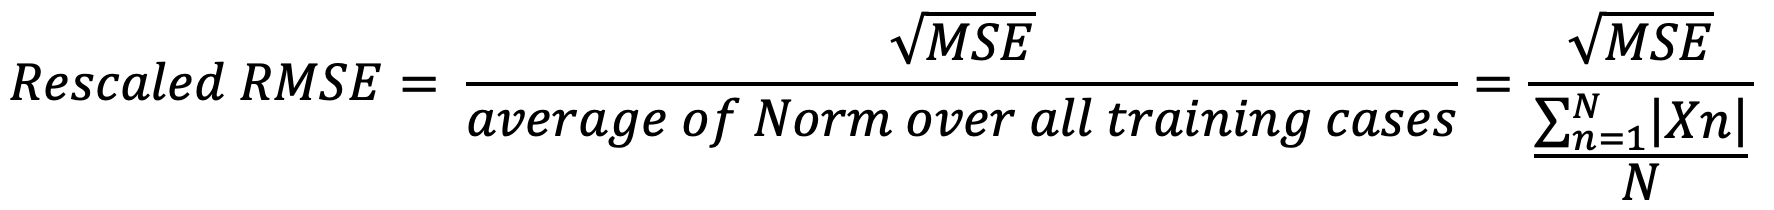


where |Xn| is the norm of case n.

At epoch number (m) = 13, both trainMSE and testMSE are approximately zero. 

Therefore, m = 13 is selected as stopping epoch for the AutoEncoder and the corresponding weights and biases are fixed and will be used later. 

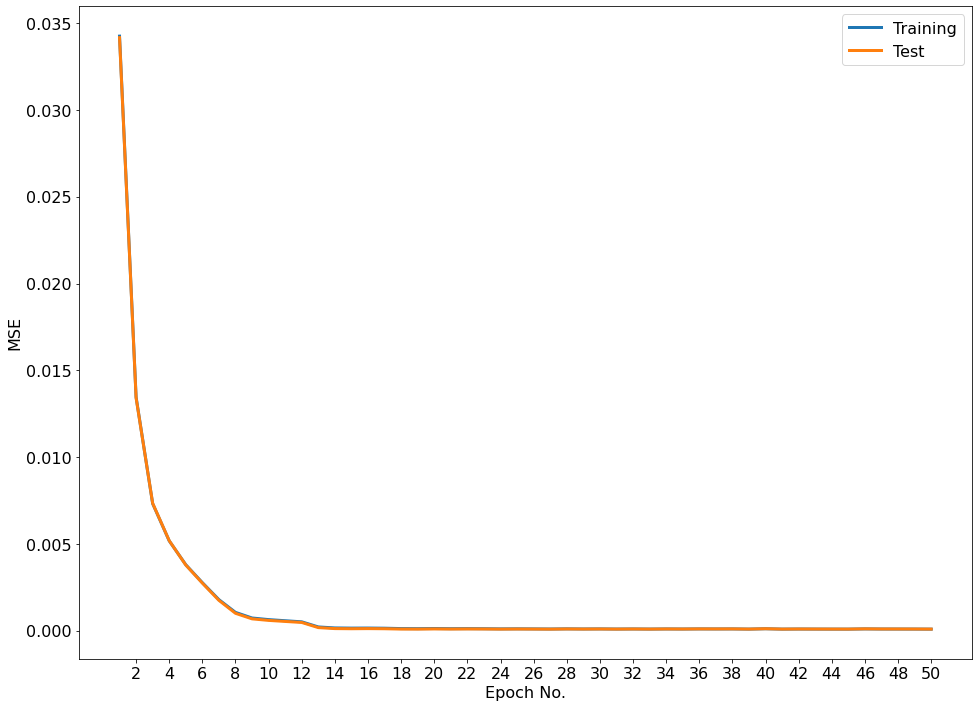

In [50]:
fig, ax = plt.subplots(1, 1)
ax.plot(AE[0], label = "Training", linewidth = 3)
ax.plot(AE[1], label = "Test", linewidth = 3)
ax.set_xticks(range(1, 51, 2))
ax.set_xticklabels(range(2, 52, 2))
ax.set_xlabel("Epoch No.")
ax.set_ylabel("MSE")
ax.legend(loc = "upper right")
plt.show()

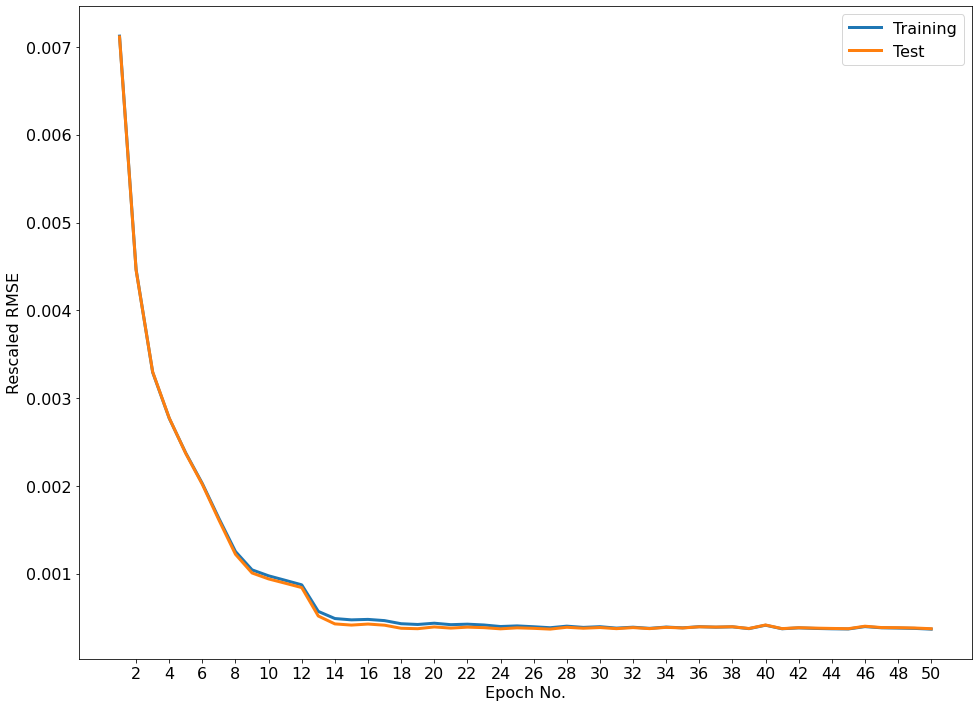

In [51]:
avnorm = np.mean(np.linalg.norm(X_train, axis = 1))

fig, ax = plt.subplots(1, 1)
ax.plot(np.sqrt(AE[0])/avnorm, label = "Training", linewidth = 3)
ax.plot(np.sqrt(AE[1])/avnorm, label = "Test", linewidth = 3)
ax.set_xticks(range(1, 51, 2))
ax.set_xticklabels(range(2, 52, 2))
ax.set_xlabel("Epoch No.")
ax.set_ylabel("Rescaled RMSE")
ax.legend(loc = "upper right")
plt.show()

# MLP with 1 hidden layer with AutoEncoder Preprocessing

A new input vector, Kn, which has dimension of h_2 was computed using the fixed weights and biases of the first half of the AutoEncoder in previous section. 

A new short classifier, MLP_AE, with one hidden layer, H_3, circled in blue below was created to compute a new probability vector Pn. 

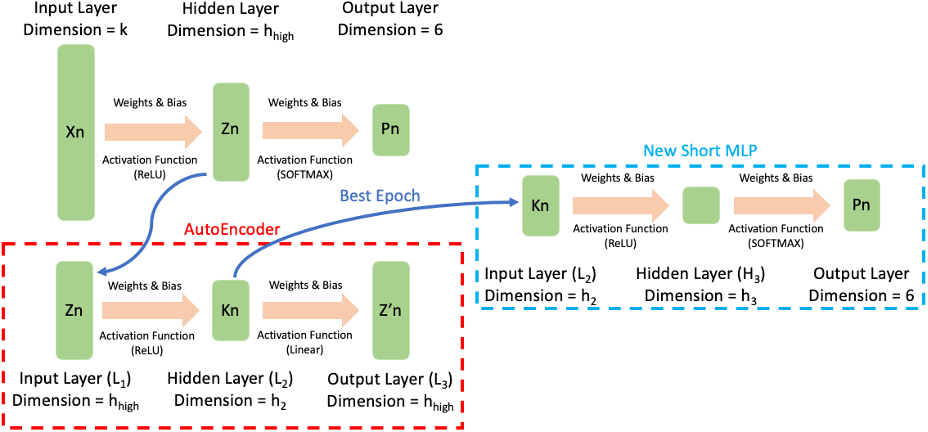

## Retrain AutoEncoder model with number of hidden layer neuron = h_AE = 26 and stop at epoch number = 13

In [52]:
best_m = 13
tf.random.set_seed(seed)
best_AE = AutoEncoder(tf.keras.optimizers.Adam(), "relu", Z_train.shape[1], h_AE, 100, best_m, Z_train, Z_test)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 26)                16926     
                                                                 
 dense_13 (Dense)            (None, 650)               17550     
                                                                 
Total params: 34,476
Trainable params: 34,476
Non-trainable params: 0
_________________________________________________________________
Epoch #  1 Finished.    Training MSE: 0.0343    Test MSE: 0.0342
Epoch #  2 Finished.    Training MSE: 0.0135    Test MSE: 0.0134
Epoch #  3 Finished.    Training MSE: 0.0073    Test MSE: 0.0073
Epoch #  4 Finished.    Training MSE: 0.0052    Test MSE: 0.0052
Epoch #  5 Finished.    Training MSE: 0.0038    Test MSE: 0.0038
Epoch #  6 Finished.    Training MSE: 0.0028    Test MSE: 0.0027
Epoch #  7 Finished.    Training MSE: 0.0018    Test MSE

In [53]:
print("Computing Time: %.1fs." % best_AE[3])

Computing Time: 46.1s.


##Extract the weights and biases from the AutoEncoder model and calculate the Kn

In [54]:
# Pull out the parameters
AE_weights = best_AE[4].get_weights()[0]
AE_bias = best_AE[4].get_weights()[1]

# Compute the new feature.
K_train = tf.keras.activations.relu(np.matmul(Z_train, AE_weights) + AE_bias)
K_test = tf.keras.activations.relu(np.matmul(Z_test, AE_weights) + AE_bias)

## Standardize the data (Kn) before apply PCA which will be used to determined the number of hidden layer neuron for the new short MLP.

In [55]:
# Standardize the data
SS = StandardScaler().fit(K_train)
c_r_K = pd.DataFrame(SS.transform(K_train))

The dimension of H3, h_3 = 15, is equal to the number of principal components that explain 90% of the variance in the input vector Kn. 

In [56]:
# PCA Analysis
pca_best_AE = PCA()
pca_best_AE.fit_transform(c_r_K)
PEV_best_AE = pca_best_AE.explained_variance_ratio_.cumsum()*100
h_best_AE = sum(PEV_best_AE < 90) + 1
h_best_AE

15

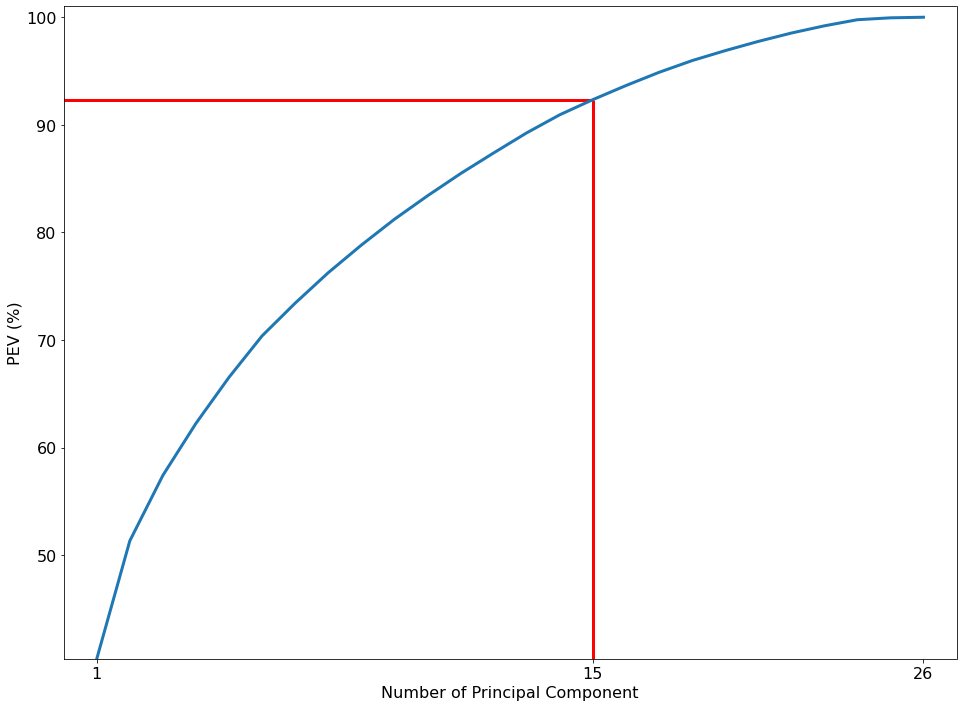

In [57]:
fig, ax = plt.subplots(1, 1)
ax.plot(PEV_best_AE, lw = 3)
ax.vlines(h_best_AE, PEV_best_AE[0] , PEV_best_AE[h_best_AE], color = "r", lw = 3)
ax.hlines(PEV_best_AE[h_best_AE], -100, h_best_AE, color = "r", lw = 3)
ax.set_xlim([-1, len(PEV_best_AE)])
ax.set_ylim([PEV_best_AE[0], 101])
ax.set_xlabel("Number of Principal Component")
ax.set_ylabel("PEV (%)")
ax.set_xticks([0, h_best_AE, K_train.shape[1]-1])
ax.set_xticklabels([1, h_best_AE, K_train.shape[1]])
plt.show()

## Train the new short MLP

In [58]:
tf.random.set_seed(seed)
MLP_AE_one_hidden = MLP_classifier(tf.keras.optimizers.Adam(), "relu", K_train.shape[1], 1, [h_best_AE], 100, 50, K_train, y_train, K_test, y_test)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 15)                405       
                                                                 
 dense_15 (Dense)            (None, 6)                 96        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
Epoch #  1 Finished.    Training Loss: 1.6843 (Overall Accuracy: 31.3%)    Test Loss: 1.7215 (Overall Accuracy: 29.4%)
Epoch #  2 Finished.    Training Loss: 1.5755 (Overall Accuracy: 36.2%)    Test Loss: 1.6330 (Overall Accuracy: 33.8%)
Epoch #  3 Finished.    Training Loss: 1.5203 (Overall Accuracy: 39.7%)    Test Loss: 1.5916 (Overall Accuracy: 36.3%)
Epoch #  4 Finished.    Training Loss: 1.4852 (Overall Accuracy: 41.0%)    Test Loss: 1.5645 (O

The performance of this short classifier model, with h = h_3 = 15 provide relatively smooth AVCRE curves which means that this makes the result more stable. This is a good sign.

Meanwhile, it can be easily observed that there is an “elbow” in below figure. Thus, the selection of epoch = 15 seems to be a good stopping epoch number for this new short MLP classifier.

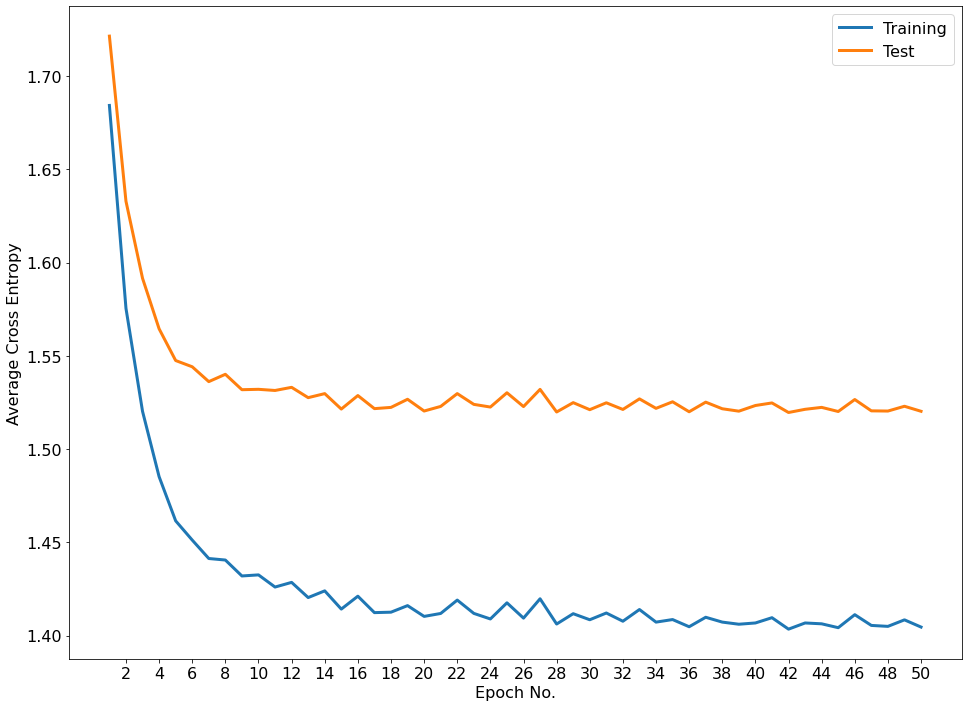

In [59]:
fig, ax = plt.subplots(1, 1)
ax.plot(MLP_AE_one_hidden[0], label = "Training", linewidth = 3)
ax.plot(MLP_AE_one_hidden[1], label = "Test", linewidth = 3)
ax.set_xticks(range(1, 51, 2))
ax.set_xticklabels(range(2, 52, 2))
ax.set_xlabel("Epoch No.")
ax.set_ylabel("Average Cross Entropy")
ax.legend(loc = "upper right")
plt.show()

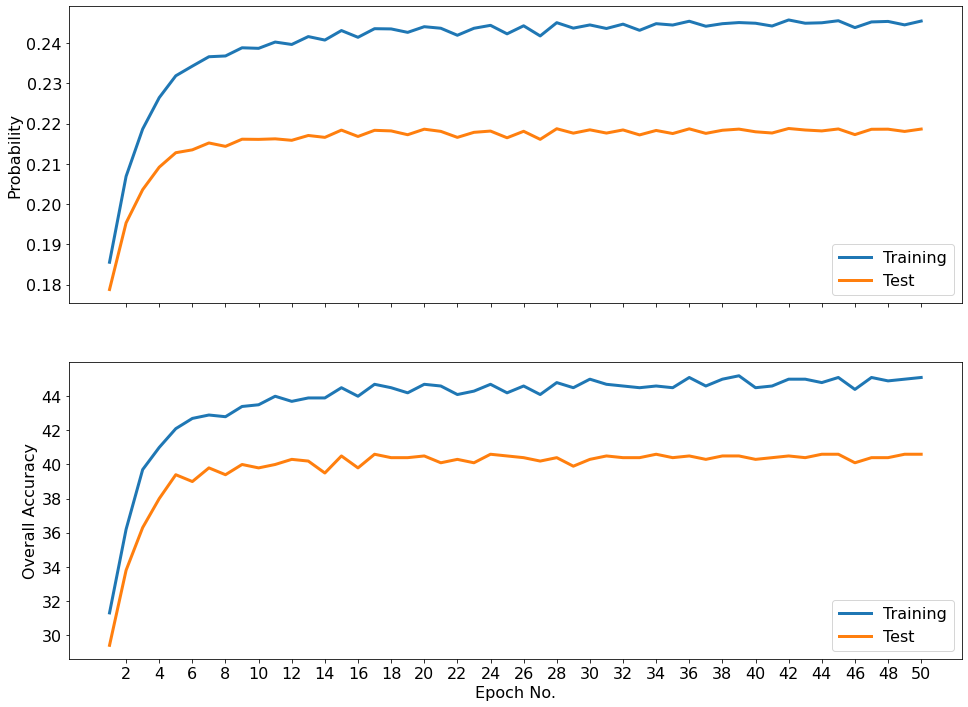

In [60]:
fig, ax = plt.subplots(2, 1, sharex = True)
ax[0].plot(np.exp(np.array(MLP_AE_one_hidden[0])*-1), label = "Training", linewidth = 3)
ax[0].plot(np.exp(np.array(MLP_AE_one_hidden[1])*-1), label = "Test", linewidth = 3)
ax[0].set_xticks(range(1, 51, 2))
ax[0].set_xticklabels(range(2, 52, 2))
# ax[0].set_xlabel("Epoch No.")
ax[0].set_ylabel("Probability")
ax[0].legend(loc = "lower right")

ax[1].plot(MLP_AE_one_hidden[5], label = "Training", linewidth = 3)
ax[1].plot(MLP_AE_one_hidden[6], label = "Test", linewidth = 3)
ax[1].set_xticks(range(1, 51, 2))
ax[1].set_xticklabels(range(2, 52, 2))
ax[1].set_xlabel("Epoch No.")
ax[1].set_ylabel("Overall Accuracy")
ax[1].legend(loc = "lower right")
plt.show()

In [61]:
stoppping_m_AE_one_hidden = 15
tf.random.set_seed(seed)
MLP_AE_one_hidden_stopping_m = MLP_classifier(tf.keras.optimizers.Adam(), "relu", K_train.shape[1], 1, [h_best_AE], 100, stoppping_m_AE_one_hidden, K_train, y_train, K_test, y_test)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 15)                405       
                                                                 
 dense_17 (Dense)            (None, 6)                 96        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
Epoch #  1 Finished.    Training Loss: 1.6843 (Overall Accuracy: 31.3%)    Test Loss: 1.7215 (Overall Accuracy: 29.4%)
Epoch #  2 Finished.    Training Loss: 1.5755 (Overall Accuracy: 36.2%)    Test Loss: 1.6330 (Overall Accuracy: 33.8%)
Epoch #  3 Finished.    Training Loss: 1.5203 (Overall Accuracy: 39.7%)    Test Loss: 1.5916 (Overall Accuracy: 36.3%)
Epoch #  4 Finished.    Training Loss: 1.4852 (Overall Accuracy: 41.0%)    Test Loss: 1.5645 (O

# Combine all the previous techniques to generate a long MLP.

A long MLP, MLP_long, will be  created using 3 hidden layers. The parameters linking two layers are obtained as below.

1. The weights and biases between input layer and hidden layer (L1) were obtained from MLP_high. 
2. The weights and biases between hidden layer (L1) and hidden layer (L2) were obtained from AutoEncoder. 
3. The weights and biases between hidden layer (L2) and hidden layer (L3) were obtained from MLP_AE. 

Finally, the softmax function will be applied to get a new probability vector with dimension of 6. 

Since all the weights and biased are obtained from each terminal model, the learning process is not required. Below figure shows the structure of MLP_long. 

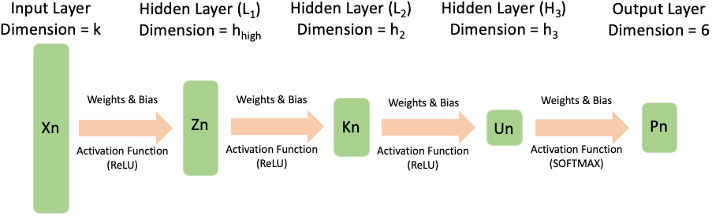

In [62]:
MLP_AE_one_hidden_weights = MLP_AE_one_hidden_stopping_m[4].get_weights()[0]
MLP_AE_one_hidden_bias = MLP_AE_one_hidden_stopping_m[4].get_weights()[1]
MLP_AE_one_hidden_weights_2 = MLP_AE_one_hidden_stopping_m[4].get_weights()[2]
MLP_AE_one_hidden_bias_2 = MLP_AE_one_hidden_stopping_m[4].get_weights()[3]

In [63]:
U_train = tf.keras.activations.relu(np.matmul(K_train, MLP_AE_one_hidden_weights) + MLP_AE_one_hidden_bias)
U_test = tf.keras.activations.relu(np.matmul(K_test, MLP_AE_one_hidden_weights) + MLP_AE_one_hidden_bias)
O_train = tf.keras.activations.relu(np.matmul(U_train, MLP_AE_one_hidden_weights_2) + MLP_AE_one_hidden_bias_2)
O_test = tf.keras.activations.relu(np.matmul(U_test, MLP_AE_one_hidden_weights_2) + MLP_AE_one_hidden_bias_2)
P_train = tf.keras.activations.softmax(O_train)
P_test = tf.keras.activations.softmax(O_test)

### Confusion Matrices

In [64]:
y_train_pred_long = np.array(P_train).argmax(axis = 1)

conf_matrix_train_long = round(pd.DataFrame(confusion_matrix(training.iloc[:,0], y_train_pred_long, normalize = "true", labels = range(n_class)))*100, 1)

conf_matrix_train_long.index.name = "True"
conf_matrix_train_long.columns.name = "Predicted"
conf_matrix_train_long.to_csv("conf_matrix_train_long (Q6).csv")
conf_matrix_train_long

Predicted,0,1,2,3,4,5
True,,,,,,
0,35.7,4.1,12.9,24.2,7.1,15.8
1,7.5,55.8,4.7,13.6,9.3,9.1
2,18.7,5.9,29.5,25.9,7.0,13.0
3,9.0,2.5,5.1,73.1,3.8,6.4
4,19.3,12.0,11.4,22.5,20.4,14.4
5,18.4,5.3,9.1,25.6,5.4,36.3


In [65]:
print("Overall Accuracy for Training Set: %.1f%%" % round(np.mean(y_train_pred_long == training.iloc[:,0])*100, 1))

Overall Accuracy for Training Set: 44.5%


In [66]:
y_test_pred_long = np.array(P_test).argmax(axis = 1)

conf_matrix_test_long = round(pd.DataFrame(confusion_matrix(test.iloc[:,0], y_test_pred_long, normalize = "true", labels = range(n_class)))*100, 1)

conf_matrix_test_long.index.name = "True"
conf_matrix_test_long.columns.name = "Predicted"
conf_matrix_test_long.to_csv("conf_matrix_test_long (Q6).csv")
conf_matrix_test_long

Predicted,0,1,2,3,4,5
True,,,,,,
0,32.0,4.6,13.0,26.5,6.2,17.7
1,7.4,50.4,4.6,16.2,9.8,11.7
2,19.1,6.6,26.3,24.7,8.3,15.0
3,9.5,3.6,6.2,70.3,3.7,6.7
4,22.9,14.6,12.8,21.8,14.6,13.2
5,18.7,5.0,9.7,27.7,6.8,32.0


In [67]:
print("Overall Accuracy for Test Set: %.1f%%" % round(np.mean(y_test_pred_long == test.iloc[:,0])*100, 1))

Overall Accuracy for Test Set: 40.5%


# Conclusion

After checking several possible MLP models in the preceding sections, below table shows the comparison between each model. 

The best overall accuracy is about 45% for training set and 40% for the test set. Also, the computing time is varied with the total number of parameters. 

It can be observed that MLP cannot do a wonderful job for image classification task. In conclusion, the overall accuracies are not good and need lengthy computational time which means that MLP cannot provide a good performance on this image classification task. 

In the future, this image classification task can be done by Convolution Neural Networks (CNN) and check if it can perform better. 

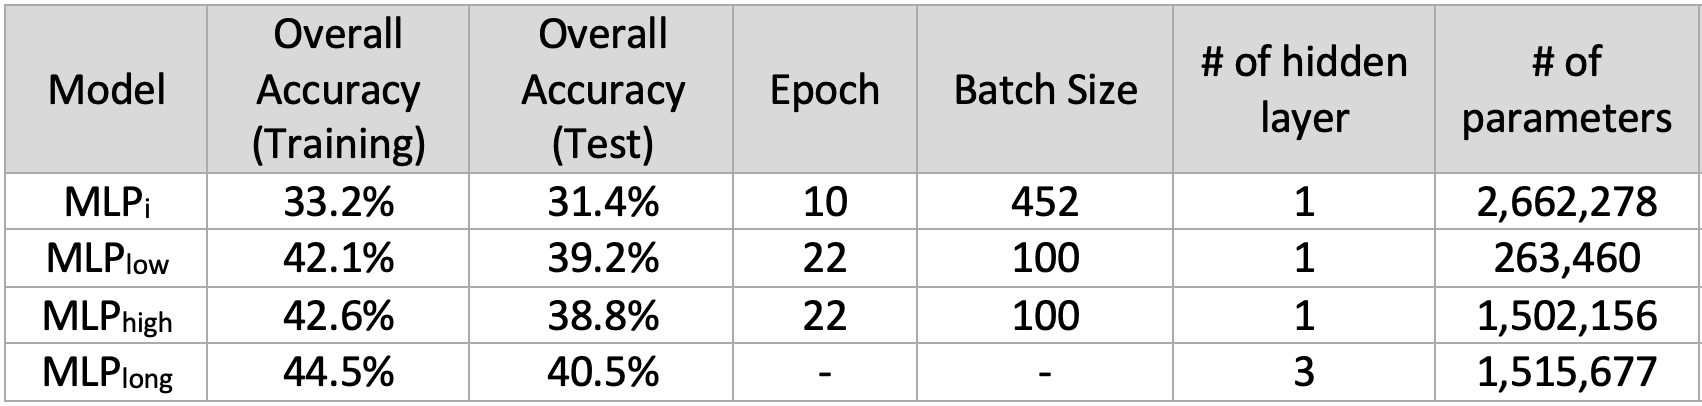